In [50]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt


In [51]:

path = "./market_data/"

# Filtrar solo los archivos que terminan en .csv
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]

# Leer cada CSV en un DataFrame y guardarlo en un diccionario
dfs = {fname.replace(".csv", ""): pd.read_csv(os.path.join(path, fname)) for fname in csv_files}


In [52]:
dfs.keys()

dict_keys(['PESOS-1305', 'AL30_1205_CI_CCL', 'dlr_may_1205', 'AL30_1205_CI_PESOS', 'AL30_1205_CI_MEP'])

In [53]:
df_al30ci = dfs['AL30_1205_CI_PESOS']
df_al30ci["fecha"] = df_al30ci["fecha_nano"].apply(lambda x: datetime.datetime.utcfromtimestamp(x*1e-9))


/tmp/ipykernel_26846/3485365850.py:2: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df_al30ci["fecha"] = df_al30ci["fecha_nano"].apply(lambda x: datetime.datetime.utcfromtimestamp(x*1e-9))


In [54]:
df_al30ci["side"].value_counts()

side
OF       1309080
BI        940321
TRADE     153901
Name: count, dtype: int64

In [55]:
import numpy as np
import pandas as pd

def build_df_for_side(df, curr_side):
    # Filtrar por side
    df_side = df[df["side"] == curr_side]
    if df_side.empty:
        return pd.DataFrame(columns=["fecha_nano", "prices", "quantities", "side"])

    # Arrays
    f = df_side["fecha_nano"].to_numpy(dtype=np.int64)
    p = df_side["price"].to_numpy(dtype=np.int32)
    q = df_side["quantity"].to_numpy(dtype=np.int32)

    # Orden estable por fecha
    order = np.argsort(f, kind="mergesort")
    f_s, p_s, q_s = f[order], p[order], q[order]

    # Agrupar por timestamp
    keys, idx, cnt = np.unique(f_s, return_index=True, return_counts=True)
    starts, ends = idx, idx + cnt

    # Construir filas
    rows = []
    for s, e, k in zip(starts, ends, keys):
        seg_p = p_s[s:e]
        seg_q = q_s[s:e]
        rows.append({
            "fecha_nano": int(k),
            "prices": seg_p[seg_p > 0].tolist(),
            "quantities": seg_q[seg_q > 0].tolist(),
            "side": curr_side
        })

    return pd.DataFrame(rows)

# Descubrir los sides presentes (p. ej. ["BI", "OF", "TRADE"])
sides_presentes = df_al30ci["side"].dropna().unique().tolist()

# Construir un dict con un DF por side
dfs_por_side = {}
for curr_side in sides_presentes:
    dfs_por_side[curr_side] = build_df_for_side(df_al30ci, curr_side)

# Concat final (mismo esquema que antes + columna 'side')
df_concat = pd.concat(dfs_por_side.values(), ignore_index=True)



In [56]:
dfs_por_side["OF"]

,fecha_nano,prices,quantities,side
0,1747058117512618279,[81900],[3000],OF
1,1747058210293570287,"[79440, 81900]","[133223, 3000]",OF
2,1747058214463031494,"[79440, 81000]","[133223, 663]",OF
3,1747058226743689670,"[79440, 81000]","[143223, 663]",OF
4,1747058290708782688,"[79440, 80400, 81000]","[143223, 266620, 663]",OF
...,...,...,...,...
265763,1747078219158102591,"[77720, 77780, 77800]","[11808, 2647, 556]",OF
265764,1747078219158320313,"[77720, 77780, 77800, 77840]","[11808, 2647, 556, 148]",OF
265765,1747078219158557609,"[77720, 77780, 77800, 77840, 77950]","[11808, 2647, 556, 148, 200000]",OF
265766,1747078426428358492,"[77720, 77780, 77800, 77840]","[11808, 2647, 556, 148]",OF


In [12]:
import pandas as pd
import numpy as np

def build_metrics(df):
    def _row_metrics(row):
        prices = np.asarray(row["prices"], dtype=float)
        qtys = np.asarray(row["quantities"], dtype=float)
        if qtys.size == 0 or np.nansum(qtys) == 0:
            return pd.Series({"vwap": np.nan, "spread": np.nan})
        vwap = np.average(prices, weights=qtys)
        var = np.average((prices - vwap) ** 2, weights=qtys)
        return pd.Series({"vwap": vwap, "spread": np.sqrt(var)})

    metrics = df.apply(_row_metrics, axis=1)
    return pd.concat([df[["fecha_nano", "side"]].reset_index(drop=True), metrics], axis=1)

df_metrics = build_metrics(df_concat)

In [13]:
df_metrics

,fecha_nano,side,vwap,spread
0,1747058117512618279,OF,81900.000000,0.000000
1,1747058210293570287,OF,79494.175873,361.023023
2,1747058214463031494,OF,79447.725080,109.505467
3,1747058226743689670,OF,79447.188191,105.649928
4,1747058290708782688,OF,80066.030996,458.897225
...,...,...,...,...
611728,1747078010499753898,TRADE,77720.000000,0.000000
611729,1747078016425763650,TRADE,77720.000000,0.000000
611730,1747078016459180789,TRADE,77720.000000,0.000000
611731,1747078019463413165,TRADE,77720.000000,0.000000


In [14]:
import pandas as pd

df_metrics = df_metrics.sort_values("fecha_nano").reset_index(drop=True)

def add_time_deltas(df, col="fecha_nano"):
    df = df.copy()
    delta_ns = df[col].diff()  # diferencia entre filas consecutivas

    df["delta_ns"] = delta_ns
    df["delta_us"] = delta_ns / 1e3   # microsegundos
    df["delta_ms"] = delta_ns / 1e6   # milisegundos
    df["delta_s"]  = delta_ns / 1e9   # segundos

    # tiempo relativo desde el primer timestamp
    first_ts = df[col].iloc[0]
    df["t_rel_ms"] = (df[col] - first_ts) / 1e6

    return df

df_metrics = add_time_deltas(df_metrics)
df_metrics = df_metrics[df_metrics["t_rel_ms"] > 4e5]


In [22]:
df_metrics

,fecha_nano,side,vwap,spread,delta_ns,delta_us,delta_ms,delta_s,t_rel_ms
0,1747058517840168177,TRADE,77590.000000,0.000000,8.688565e+08,8.688565e+05,868.856492,0.868856,4.003275e+05
1,1747058517847546493,TRADE,77590.000000,0.000000,7.378316e+06,7.378316e+03,7.378316,0.007378,4.003349e+05
2,1747058517870543060,TRADE,77590.000000,0.000000,2.299657e+07,2.299657e+04,22.996567,0.022997,4.003579e+05
3,1747058517873965247,OF,77641.133572,19.620617,3.422187e+06,3.422187e+03,3.422187,0.003422,4.003613e+05
4,1747058517905895259,BI,77535.817171,14.534895,3.193001e+07,3.193001e+04,31.930012,0.031930,4.003933e+05
...,...,...,...,...,...,...,...,...,...
610039,1747078259405494646,BI,77709.004279,7.577384,4.024694e+10,4.024694e+07,40246.937037,40.246937,2.014189e+07
610040,1747078259405713714,BI,77708.526649,10.440342,2.190680e+05,2.190680e+02,0.219068,0.000219,2.014189e+07
610041,1747078288919089629,BI,77708.526954,10.440404,2.951338e+10,2.951338e+07,29513.375915,29.513376,2.017141e+07
610042,1747078426428358492,OF,77734.582756,28.129843,1.375093e+11,1.375093e+08,137509.268863,137.509269,2.030892e+07


In [36]:
import numpy as np
import pandas as pd

df = df_metrics.copy()
df["ts"] = pd.to_datetime(df["fecha_nano"], unit="ns")
df = df.sort_values(["side", "ts"])

def compute_instantaneous_returns(g):
    g = g.sort_values("ts").copy()
    p = g["vwap"].astype(float)
    dt = g["ts"].diff().dt.total_seconds()
    log_ret = np.log(p).diff()
    g["r_instant"] = log_ret / dt
    return g

df_ret = df.groupby("side", group_keys=False).apply(compute_instantaneous_returns)

df_trade = df_ret[df_ret["side"] == "TRADE"].reset_index(drop=True)
df_bi = df_ret[df_ret["side"] == "BI"].reset_index(drop=True)
df_of = df_ret[df_ret["side"] == "OF"].reset_index(drop=True)

df_metrics = pd.concat([df_trade, df_bi, df_of])


/tmp/ipykernel_26846/156907294.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ret = df.groupby("side", group_keys=False).apply(compute_instantaneous_returns)


## Elegimos una ventana

Side=TRADE: 50 puntos en ventana [1000000.000, 1005000.000] ms
Side=BI: 80 puntos en ventana [1000000.000, 1005000.000] ms
Side=OF: 93 puntos en ventana [1000000.000, 1005000.000] ms


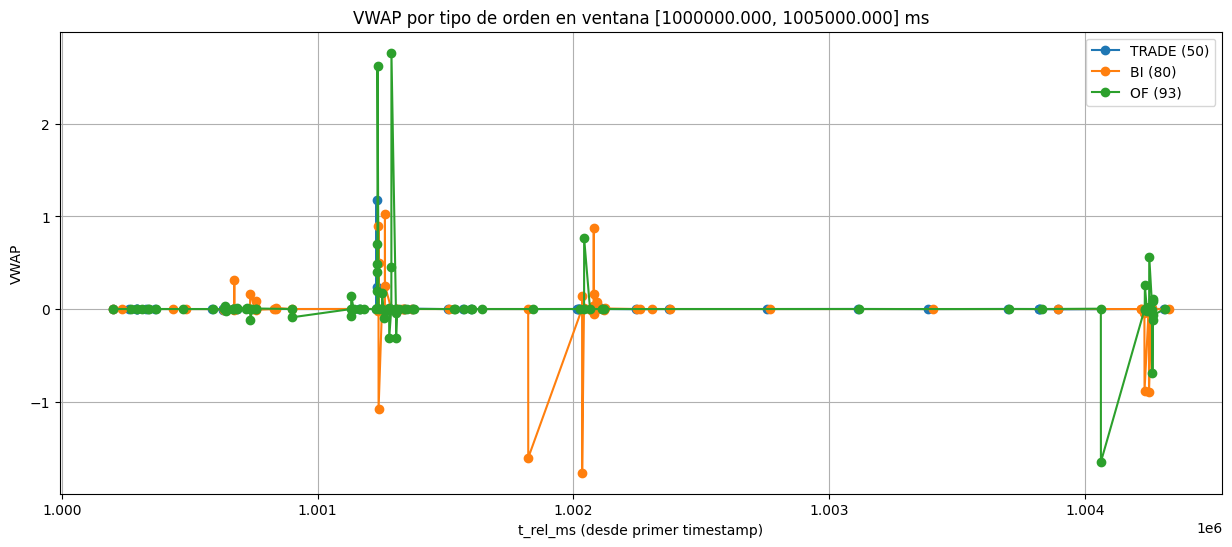

,fecha_nano,side,vwap,spread,delta_ns,delta_us,delta_ms,delta_s,t_rel_ms,ts,r_instant
21520,1747059117710992687,TRADE,77180.000000,0.000000,303310450.0,303310.450,303.310450,0.303310,1.000198e+06,2025-05-12 14:11:57.710992687,1.185545e-03
21521,1747059117713828118,BI,77119.021940,20.417003,2835431.0,2835.431,2.835431,0.002835,1.000201e+06,2025-05-12 14:11:57.713828118,2.239274e-05
21522,1747059117713987140,OF,77198.437034,18.857808,159022.0,159.022,0.159022,0.000159,1.000201e+06,2025-05-12 14:11:57.713987140,2.421064e-08
21523,1747059117746052884,BI,77118.964492,21.006636,32065744.0,32065.744,32.065744,0.032066,1.000233e+06,2025-05-12 14:11:57.746052884,-2.311624e-05
21524,1747059117776755801,TRADE,77180.000000,0.000000,30702917.0,30702.917,30.702917,0.030703,1.000264e+06,2025-05-12 14:11:57.776755801,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
21738,1747059121779747626,OF,77248.836727,35.756213,1305110.0,1305.110,1.305110,0.001305,1.004267e+06,2025-05-12 14:12:01.779747626,-1.230442e-01
21739,1747059121780198944,OF,77246.574866,33.149861,451318.0,451.318,0.451318,0.000451,1.004268e+06,2025-05-12 14:12:01.780198944,-6.487801e-02
21740,1747059121820710881,TRADE,77210.000000,0.000000,40511937.0,40511.937,40.511937,0.040512,1.004308e+06,2025-05-12 14:12:01.820710881,9.384583e-04
21741,1747059121824651857,OF,77246.734947,33.133706,3940976.0,3940.976,3.940976,0.003941,1.004312e+06,2025-05-12 14:12:01.824651857,4.661849e-05


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def select_time_window_by_time(df, t_start_ms=None, t_end_ms=None, window_ms=None, time_col="t_rel_ms"):
    if len(df) == 0:
        return df.copy(), (np.nan, np.nan)

    df_sorted = df.sort_values(time_col).reset_index(drop=True)
    t_min, t_max = df_sorted[time_col].iloc[0], df_sorted[time_col].iloc[-1]

    if t_start_ms is not None and window_ms is not None:
        t_start, t_end = t_start_ms, t_start_ms + window_ms
    elif t_end_ms is not None and window_ms is not None:
        t_start, t_end = t_end_ms - window_ms, t_end_ms
    elif t_start_ms is not None and t_end_ms is not None:
        t_start, t_end = t_start_ms, t_end_ms
    else:
        raise ValueError("Especificá (t_start_ms y window_ms) o (t_end_ms y window_ms) o (t_start_ms y t_end_ms).")

    if t_start > t_end:
        t_start, t_end = t_end, t_start
    t_start = max(t_min, t_start)
    t_end   = min(t_max, t_end)

    mask = (df[time_col] >= t_start) & (df[time_col] <= t_end)
    return df.loc[mask].copy(), (t_start, t_end)

def plot_vwap_window_time(df_metrics, t_start_ms=None, t_end_ms=None, window_ms=None,
                          sample_step: int = 1, per_side_head_frac: float = 1.0):
    df_win, (t_start, t_end) = select_time_window_by_time(
        df_metrics, t_start_ms=t_start_ms, t_end_ms=t_end_ms, window_ms=window_ms, time_col="t_rel_ms"
    )
    if len(df_win) == 0:
        print("Ventana sin datos.")
        return

    plt.figure(figsize=(15, 6))
    for curr_side in df_win["side"].dropna().unique():
        df_side = df_win[df_win["side"] == curr_side].sort_values("t_rel_ms")
        if sample_step > 1:
            df_side = df_side.iloc[::sample_step, :]
        if 0 < per_side_head_frac < 1:
            n_keep = max(1, int(len(df_side) * per_side_head_frac))
            df_side = df_side.head(n_keep)
        if len(df_side) == 0:
            continue

        # imprimir cantidad de puntos
        print(f"Side={curr_side}: {len(df_side)} puntos en ventana [{t_start:.3f}, {t_end:.3f}] ms")

        # también mostrarlo en la leyenda
        plt.plot(df_side["t_rel_ms"], df_side["r_instant"], '-o', label=f"{curr_side} ({len(df_side)})")

    plt.xlabel("t_rel_ms (desde primer timestamp)")
    plt.ylabel("VWAP")
    plt.title(f"VWAP por tipo de orden en ventana [{t_start:.3f}, {t_end:.3f}] ms")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df_win

# Ejemplo de uso
df_metrics = df_metrics.sort_values("t_rel_ms").reset_index(drop=True)
df_win = plot_vwap_window_time(df_metrics, t_start_ms=1e6, window_ms=5e3, sample_step=1)

df_win


In [57]:
df_metrics.head()

,fecha_nano,side,vwap,spread,delta_ns,delta_us,delta_ms,delta_s,t_rel_ms,ts,r_instant
0,1747058517840168177,TRADE,77590.000000,0.000000,868856492.0,868856.492,868.856492,0.868856,400327.549898,2025-05-12 14:01:57.840168177,NaN
1,1747058517847546493,TRADE,77590.000000,0.000000,7378316.0,7378.316,7.378316,0.007378,400334.928214,2025-05-12 14:01:57.847546493,0.0
2,1747058517870543060,TRADE,77590.000000,0.000000,22996567.0,22996.567,22.996567,0.022997,400357.924781,2025-05-12 14:01:57.870543060,0.0
3,1747058517873965247,OF,77641.133572,19.620617,3422187.0,3422.187,3.422187,0.003422,400361.346968,2025-05-12 14:01:57.873965247,NaN
4,1747058517905895259,BI,77535.817171,14.534895,31930012.0,31930.012,31.930012,0.031930,400393.276980,2025-05-12 14:01:57.905895259,NaN


## Aplicando EWMA

In [44]:
import pandas as pd

df = df_win.copy()
df = df[['fecha_nano', 'r_instant', 'spread', 'side']].dropna(subset=['r_instant', 'spread'])
df = df.sort_values('fecha_nano')

dfs_by_side = {
    s: g[['fecha_nano', 'r_instant', 'spread']].reset_index(drop=True)
    for s, g in df.groupby('side', sort=False)
}

series_by_side = {
    s: {
        'r_instant': g.set_index('fecha_nano')['r_instant'],
        'spread': g.set_index('fecha_nano')['spread'],
    }
    for s, g in df.groupby('side', sort=False)
}


In [45]:
import pandas as pd

def ewma_nowcast_row(series_by_side, t_new, alpha=0.3):
    out = {}
    for side, series_dict in series_by_side.items():
        for col, s in series_dict.items():
            s = s.sort_index()
            if t_new in s.index:
                val = s.loc[t_new]
            else:
                s_up = s.loc[:t_new]
                if len(s_up) == 0:
                    val0 = s.iloc[0]
                    ew0 = val0
                    val = alpha * val0 + (1 - alpha) * ew0
                else:
                    last_val = s_up.iloc[-1]
                    ew = s_up.ewm(alpha=alpha, adjust=False).mean().iloc[-1]
                    val = alpha * last_val + (1 - alpha) * ew
            out[f"{side}_{col}"] = val
    row = pd.DataFrame(out, index=[t_new])
    return row

# ejemplo de uso:
# t_new = int(...)  # un fecha_nano objetivo
# row = ewma_nowcast_row(series_by_side, t_new, alpha=0.3)
# row  # DataFrame 1x(2*#sides) con columnas tipo "OF_vwap", "OF_spread", ...



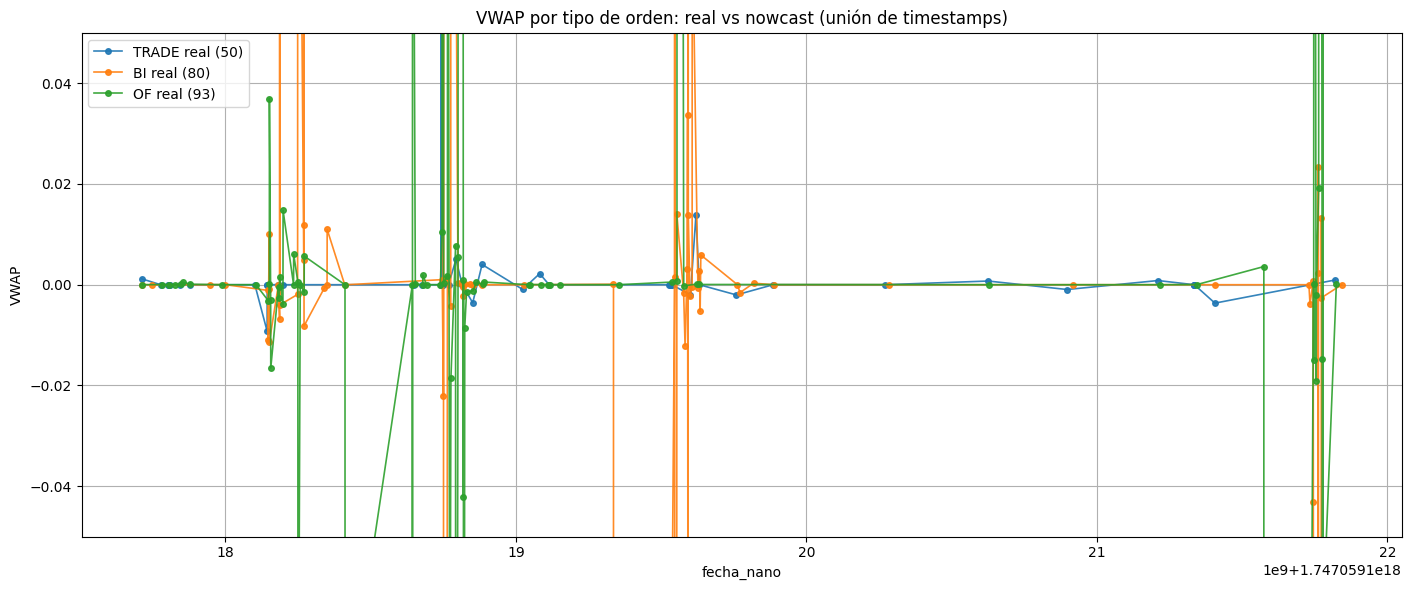

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

alpha = 0.3
sides = [s for s in ["TRADE","BI","OF"] if s in series_by_side]

# unión de timestamps (VWAP) de todos los sides
t_union = sorted(set().union(*[set(series_by_side[s]["r_instant"].sort_index().index) for s in sides]))

# panel de nowcasts en todos los timestamps de la unión
rows = [ewma_nowcast_row(series_by_side, t, alpha=alpha) for t in t_union]
panel_nowcast = pd.concat(rows).sort_index()

# plot: 3 sides x (original + nowcast) = 6 series
plt.figure(figsize=(14,6))

for side in sides:
    n = len(series_by_side[side]["r_instant"])
    # original (puntos y línea fina)
    plt.plot(series_by_side[side]["r_instant"].sort_index(),
             marker='o', markersize=4, linewidth=1.2, alpha=0.9,
             label=f"{side} real ({n})")
    # nowcast (línea punteada sobre la grilla común)
    col = f"{side}_vwap"
    if col in panel_nowcast.columns:
        plt.plot(panel_nowcast.index, panel_nowcast[col], '-o', linewidth=1.8,
                 label=f"{side} nowcast (α={alpha})")

plt.title("VWAP por tipo de orden: real vs nowcast (unión de timestamps)")
plt.xlabel("fecha_nano")
plt.ylabel("VWAP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(-5e-2,5e-2)
plt.show()


In [47]:
import numpy as np
import pandas as pd

alpha = 0.3
sides = [s for s in ["TRADE","BI","OF"] if s in series_by_side]
cols = [c for c in ["vwap","spread"] if all(c in series_by_side[s] for s in sides)]

t_union = sorted(set().union(*[set(series_by_side[s][cols[0]].sort_index().index) for s in sides]))
rows = [ewma_nowcast_row(series_by_side, t, alpha=alpha) for t in t_union]
panel_nowcast = pd.concat(rows).sort_index()

colnames = [f"{s}_{c}" for s in sides for c in cols]
values_df = panel_nowcast[colnames].copy()

is_real_df = pd.DataFrame(False, index=values_df.index, columns=values_df.columns)
for s in sides:
    for c in cols:
        col = f"{s}_{c}"
        idx_real = series_by_side[s][c].sort_index().index
        is_real_df[col] = values_df.index.isin(idx_real)

values_df.head(), is_real_df.head()


(                     TRADE_spread  BI_spread  OF_spread
 1747059117710992687           0.0  20.417003  18.857808
 1747059117713828118           0.0  20.417003  18.857808
 1747059117713987140           0.0  20.417003  18.857808
 1747059117746052884           0.0  21.006636  18.857808
 1747059117776755801           0.0  20.717716  18.857808,
                      TRADE_spread  BI_spread  OF_spread
 1747059117710992687          True      False      False
 1747059117713828118         False       True      False
 1747059117713987140         False      False       True
 1747059117746052884         False       True      False
 1747059117776755801          True      False      False)

In [48]:
len(values_df)

223